#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* (선택) 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* (선택) 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
  - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

In [ ]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='train_err', marker = '.')
    plt.plot(history.history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [ ]:
# 주어진 데이터 셋을 불러오세요.(3개)
train_data=pd.read_csv(path+'data01_train.csv')
test_data=pd.read_csv(path+'data01_test.csv')
feature_data=pd.read_csv(path+'features.csv')

In [ ]:
#불필요한 칼럼을 삭제하세요.
train_data.drop('subject',axis=1,inplace=True)
test_data.drop('subject',axis=1,inplace=True)

#### 2) 기본 정보 조회

In [ ]:
#전체 데이터의 행,열 개수 확인
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 6.3+ MB


In [ ]:
#전체 데이터의 상위 5개 행 확인
train_data.head()
test_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


In [ ]:
#전체 데이터의 수치형 변수 분포 확인
train_data.describe()
test_data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,...,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000
mean,0.273198,-0.017281,-0.108123,-0.614634,-0.515427,-0.607533,-0.639950,-0.530760,-0.609256,-0.481055,...,0.118651,-0.311513,-0.632273,0.009324,0.015666,0.006272,-0.001510,-0.481737,0.055771,-0.064194
std,0.079989,0.045957,0.049082,0.448480,0.506094,0.424243,0.422994,0.489381,0.418536,0.542756,...,0.258112,0.313792,0.296179,0.324864,0.452616,0.608954,0.483028,0.522714,0.298124,0.281645
min,-1.000000,-1.000000,-0.418354,-0.999717,-0.999873,-1.000000,-0.999867,-1.000000,-0.999879,-0.948723,...,-1.000000,-0.995357,-0.994664,-0.937468,-0.990492,-0.995222,-0.969066,-0.999380,-0.995073,-1.000000
25%,0.263787,-0.024792,-0.120733,-0.992669,-0.979082,-0.981070,-0.993498,-0.979214,-0.980659,-0.936791,...,-0.035193,-0.546342,-0.844547,-0.119166,-0.265533,-0.485998,-0.380300,-0.814060,-0.017413,-0.148445
50%,0.277322,-0.017187,-0.108124,-0.952426,-0.867309,-0.869890,-0.958705,-0.873891,-0.863451,-0.890491,...,0.135282,-0.347433,-0.706699,0.005049,0.023421,-0.005036,0.002408,-0.708911,0.178814,-0.002243
75%,0.288058,-0.010238,-0.096606,-0.245405,-0.030639,-0.260223,-0.297260,-0.058824,-0.256657,-0.030692,...,0.289832,-0.125796,-0.516910,0.135698,0.312690,0.518184,0.374583,-0.486534,0.248126,0.096674
max,0.631510,0.359587,0.543939,0.899922,0.782590,0.931308,0.950758,0.602458,0.784041,0.821218,...,0.860512,0.941113,0.894210,0.980889,0.991899,0.994366,0.979522,1.000000,0.432496,0.992766


In [ ]:
#전체 데이터의 모든 변수 확인
train_data.columns
test_data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [ ]:
#Lable 추가(1단계 모델:정적(0), 동적(1) 행동 분류 모델 생성 )
activity_map = {
    'STANDING': 0,
    'SITTING': 0,
    'LAYING': 0,
    'WALKING': 1,
    'WALKING_UPSTAIRS': 1,
    'WALKING_DOWNSTAIRS': 1
}

# 'Activity' 컬럼을 매핑하여 'is_dynamic' 컬럼 생성
train_data['is_dynamic'] = train_data['Activity'].map(activity_map)

### (2) x, y 분리

In [ ]:
#x,y 분리하기
X = train_data.drop(columns=['Activity', 'is_dynamic'])
y = train_data['is_dynamic']

### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### (4) 데이터 분할
* train, val 분할

In [ ]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=10, stratify=y
)

## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.(기본 모델링 참고)

#### 1) 모델1

In [ ]:
# 모델 설계
def create_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # 이진 분류 모델
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 모델 생성
model = create_model(x_train.shape[1])

# 모델 요약
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        35,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,081 (148.75 KB)

 Trainable params: 38,081 (148.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 컴파일 및 학습
# 학습
es_static = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=32, callbacks=[es_static],verbose=1)

Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9579 - loss: 0.0895 - val_accuracy: 1.0000 - val_loss: 7.9606e-04
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 1.0000 - loss: 5.0753e-04 - val_accuracy: 1.0000 - val_loss: 2.5187e-04
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 1.0000 - loss: 1.4980e-04 - val_accuracy: 1.0000 - val_loss: 1.6524e-04
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 8.2169e-05 - val_accuracy: 1.0000 - val_loss: 1.3762e-04
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 6.1323e-05 - val_accuracy: 1.0000 - val_loss: 1.0947e-04
Epoch 6/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 4.3399e-05 - val_accuracy: 1.0000 - val_loss: 9.5485e-05
Epoch 7/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 3.6029e-05 - val_accuracy: 1.0000 - val_loss: 8.7230e-05
Epoch 8/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/st

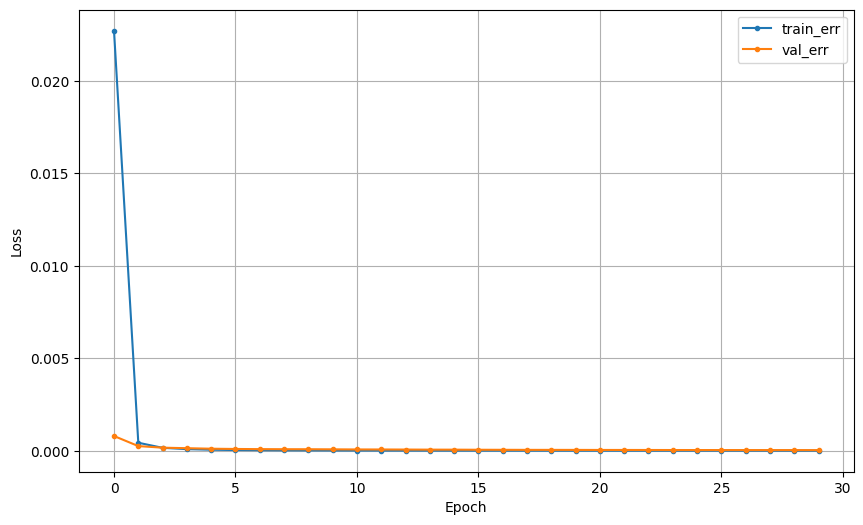

In [ ]:
# 학습곡선
dl_history_plot(history)

In [ ]:
# 예측 및 평가
y_pred_prob = model.predict(x_val)
y_pred = (y_pred_prob > 0.5).astype(int)

# 정확도 및 주요 평가 지표 출력
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


#### 2) 모델2

In [ ]:
# 모델 설계
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# 모델 설계
def create_model2(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # 이진 분류 모델
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 모델 생성
model2 = create_model2(x_train.shape[1])

# 모델 요약
model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │        35,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,081 (148.75 KB)

 Trainable params: 38,081 (148.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 컴파일 및 학습
history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=60, batch_size=32, verbose=1)


Epoch 1/60
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9632 - loss: 0.0747 - val_accuracy: 1.0000 - val_loss: 5.9504e-04
Epoch 2/60
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 6.5585e-04 - val_accuracy: 1.0000 - val_loss: 1.9161e-04
Epoch 3/60
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 1.8120e-04 - val_accuracy: 1.0000 - val_loss: 9.3097e-05
Epoch 4/60
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 7.1848e-05 - val_accuracy: 1.0000 - val_loss: 6.3149e-05
Epoch 5/60
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 6.1568e-05 - val_accuracy: 1.0000 - val_loss: 4.4481e-05
Epoch 6/60
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 4.3020e-05 - val_accuracy: 1.0000 - val_loss: 3.4020e-05
Epoch 7/60
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 4.0407e-05 - val_accuracy: 1.0000 - val_loss: 2.7115e-05
Epoch 8/60
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

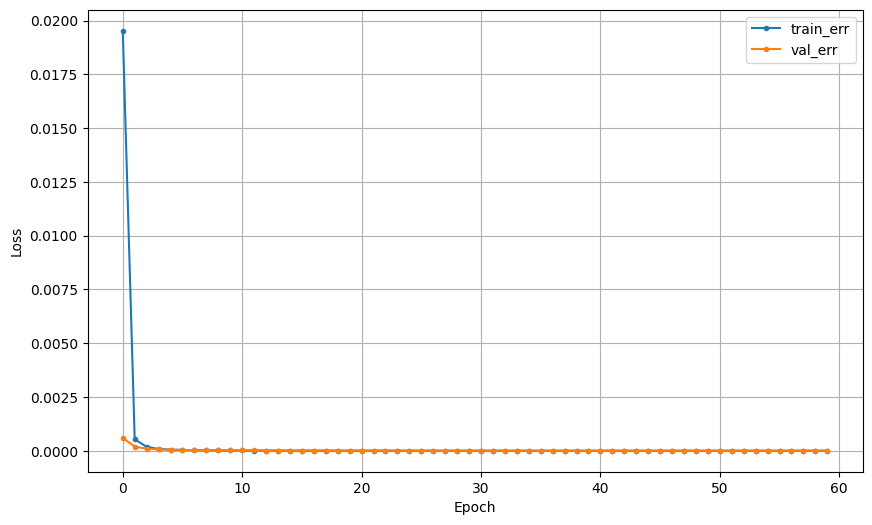

In [ ]:
# 학습곡선
dl_history_plot(history2)

In [ ]:
# 예측 및 평가
y_pred_prob2 = model2.predict(x_val)
y_pred2 = (y_pred_prob2 > 0.5).astype(int)

# 정확도 및 주요 평가 지표 출력
print("Accuracy:", accuracy_score(y_val, y_pred2))
print("Precision:", precision_score(y_val, y_pred2))
print("Recall:", recall_score(y_val, y_pred2))
print("F1 Score:", f1_score(y_val, y_pred2))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
# (tip) 정적 행동(0)인 데이터 추출
# 정적 행동 (Laying, Sitting, Standing)만 추출
static_data = train_data[train_data['is_dynamic'] == 0]

# X, y로 분리
X_static = static_data.drop(columns=['Activity', 'is_dynamic'])
y_static = static_data['Activity']

In [ ]:
X_static

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.032207,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.246705,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.388765,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755
7,0.272026,-0.001329,-0.125491,-0.992068,-0.912985,-0.972451,-0.994752,-0.943141,-0.976428,-0.925446,...,-0.288935,-0.258503,-0.704995,-0.024442,0.076332,0.741277,0.729812,-0.817201,0.037746,0.136129
8,0.284338,0.021956,-0.006925,-0.980153,-0.838394,-0.782357,-0.983683,-0.816199,-0.743923,-0.914011,...,-0.194271,-0.052863,-0.400197,0.021212,-0.009465,-0.282762,0.563343,-0.782072,0.242834,-0.025285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5874,0.257476,-0.413865,0.017374,-0.919666,0.075259,-0.630716,-0.937986,0.176796,-0.613510,-0.866296,...,-0.269565,0.285085,-0.091605,-0.000793,0.267189,-0.186202,0.098099,0.792970,-0.034020,-0.928148
5875,0.277378,-0.013298,-0.104322,-0.996596,-0.987491,-0.973345,-0.996372,-0.987746,-0.973512,-0.942156,...,0.388907,-0.750064,-0.956239,0.122320,0.136275,-0.708377,-0.507788,-0.818263,0.222620,0.035430
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,0.052914,-0.305772,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,0.362439,-0.597610,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840


In [ ]:
# (tip) 인코딩 진행, map 활용해서 숫자레이블로 매핑핑
# Laying, Sitting, Standing을 숫자 레이블로 매핑
activity_map_static = {
    'LAYING': 0,
    'SITTING': 1,
    'STANDING': 2
}

y_static_encoded = y_static.map(activity_map_static)
# 스케일링 (StandardScaler 사용)
scaler_static = StandardScaler()
X_static_scaled = scaler_static.fit_transform(X_static)

x_train2, x_val2, y_train2, y_val2 = train_test_split(X_static_scaled, y_static_encoded, test_size=0.2, random_state=10, stratify=y_static_encoded)

In [ ]:
# 모델 설계
model_static = Sequential([
    Dense(64, activation='relu', input_shape=(X_static_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 다중 클래스 분류이므로 softmax 사용
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# 컴파일 및 학습
model_static.compile(optimizer=Adam(learning_rate=0.001),
                     loss='sparse_categorical_crossentropy',  # 정수 레이블을 사용하므로 sparse_categorical_crossentropy
                     metrics=['accuracy'])

es_static = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history_static = model_static.fit(x_train2, y_train2, validation_data=(x_val2, y_val2), epochs=30, batch_size=32, callbacks=[es_static],verbose=1)


Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5973 - loss: 0.9258 - val_accuracy: 0.8841 - val_loss: 0.3235
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8603 - loss: 0.3671 - val_accuracy: 0.9304 - val_loss: 0.1837
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9128 - loss: 0.2254 - val_accuracy: 0.9258 - val_loss: 0.1644
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9338 - loss: 0.1914 - val_accuracy: 0.9645 - val_loss: 0.1348
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9499 - loss: 0.1375 - val_accuracy: 0.9320 - val_loss: 0.1623
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9600 - loss: 0.1165 - val_accuracy: 0.9536 - val_loss: 0.1274
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9648 - loss: 0.1017 - val_accuracy: 0.9598 - val_loss: 0.1261
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9675 - loss: 0.0830 - val_accuracy: 0.9660 - val_loss

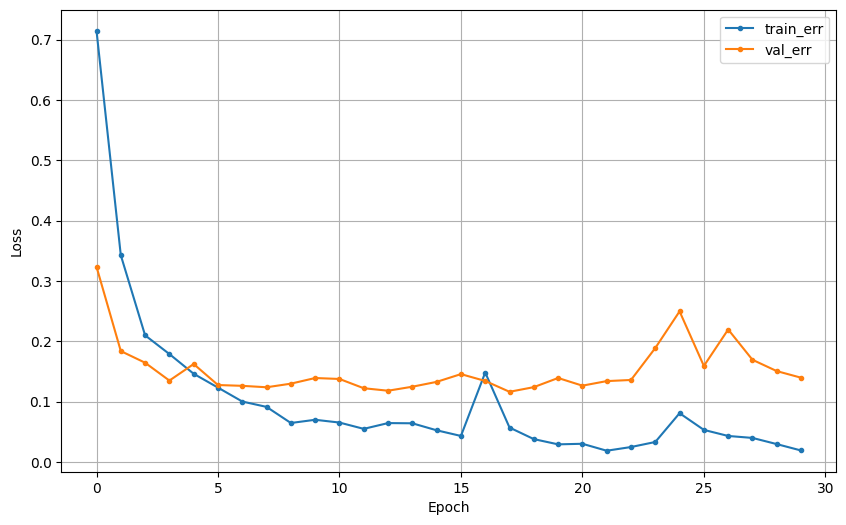

In [ ]:
# 학습곡선
dl_history_plot(history_static)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✅ Validation Set 평가
Accuracy: 0.9675425038639877
Precision: 0.9681356770660204
Recall: 0.9675425038639877
F1 Score: 0.9675248845996826


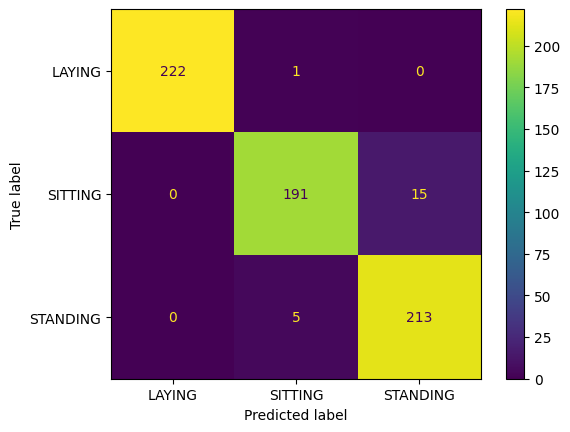

In [ ]:
# ⛳️ 검증 데이터로 예측 및 평가
y_val_pred_prob = model_static.predict(x_val2)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)

# 🎯 성능 평가
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

print("✅ Validation Set 평가")
print("Accuracy:", accuracy_score(y_val2, y_val_pred))
print("Precision:", precision_score(y_val2, y_val_pred, average='weighted'))
print("Recall:", recall_score(y_val2, y_val_pred, average='weighted'))
print("F1 Score:", f1_score(y_val2, y_val_pred, average='weighted'))

# Confusion Matrix
cm_static = confusion_matrix(y_val2, y_val_pred)
disp_static = ConfusionMatrixDisplay(confusion_matrix=cm_static, display_labels=['LAYING', 'SITTING', 'STANDING'])
disp_static.plot()


#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
# 동적 행동 (Walking, Walking-Upstairs, Walking-Downstairs)만 추출
dynamic_data = train_data[train_data['is_dynamic'] == 1]

# X, y로 분리
X_dynamic = dynamic_data.drop(columns=['Activity', 'is_dynamic'])
y_dynamic = dynamic_data['Activity']

In [ ]:
# (tip) map 활용해서 숫자레이블로 매핑핑
# Walking, Walking-Upstairs, Walking-Downstairs를 숫자 레이블로 매핑
activity_map_dynamic = {
    'WALKING': 0,
    'WALKING_UPSTAIRS': 1,
    'WALKING_DOWNSTAIRS': 2
}

y_dynamic_encoded = y_dynamic.map(activity_map_dynamic)
# 스케일링 (StandardScaler 사용)
scaler_dynamic = StandardScaler()
X_dynamic_scaled = scaler_dynamic.fit_transform(X_dynamic)

x_train3, x_val3, y_train3, y_val3 = train_test_split(X_dynamic_scaled, y_dynamic_encoded, test_size=0.2, random_state=10, stratify=y_dynamic_encoded)

In [ ]:
# 모델 설계
model_dynamic = Sequential([
    Dense(64, activation='relu', input_shape=(X_dynamic_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 다중 클래스 분류이므로 softmax 사용
])

# 모델 컴파일
model_dynamic.compile(optimizer=Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',  # 정수 레이블을 사용하므로 sparse_categorical_crossentropy
                      metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# 컴파일 및 학습
# 조기 종료 콜백
es_dynamic = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history_dynamic = model_dynamic.fit(x_train3, y_train3, validation_data=(x_val3, y_val3), epochs=30, batch_size=32, callbacks=[es_static],verbose=1)

Epoch 1/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6420 - loss: 0.8412 - val_accuracy: 0.9679 - val_loss: 0.1144
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9464 - loss: 0.1633 - val_accuracy: 0.9849 - val_loss: 0.0371
Epoch 3/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9785 - loss: 0.0675 - val_accuracy: 0.9943 - val_loss: 0.0286
Epoch 4/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9812 - loss: 0.0631 - val_accuracy: 0.9906 - val_loss: 0.0319
Epoch 5/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9899 - loss: 0.0398 - val_accuracy: 0.9943 - val_loss: 0.0164
Epoch 6/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9953 - loss: 0.0177 - val_accuracy: 0.9962 - val_loss: 0.0065
Epoch 7/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9936 - loss: 0.0191 - val_accuracy: 0.9981 - val_loss: 0.0054
Epoch 8/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9911 - loss: 0.0210 - val_accuracy: 0.9981 - val_loss:

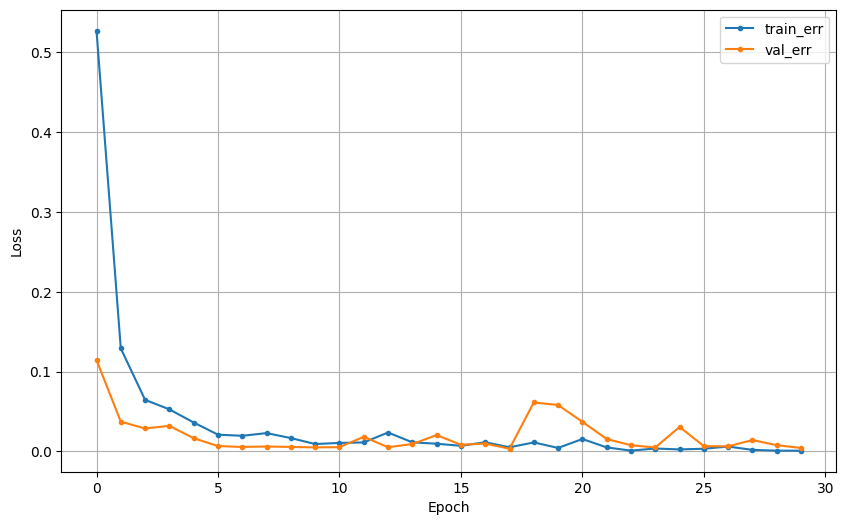

In [ ]:
# 학습곡선 시각화
dl_history_plot(history_dynamic)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
✅ 동적 동작 분류 - Validation Set 평가
Accuracy: 0.9981132075471698
Precision: 0.99812507416637
Recall: 0.9981132075471698
F1 Score: 0.9981138191589325


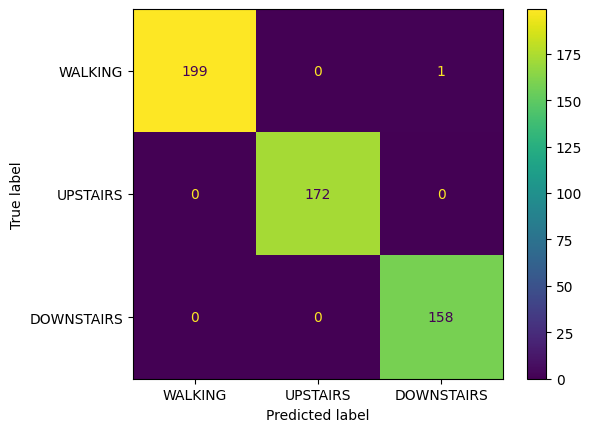

In [ ]:
# (5) 검증 데이터 예측
y_dynamic_pred_prob = model_dynamic.predict(x_val3)
y_dynamic_pred = np.argmax(y_dynamic_pred_prob, axis=1)

# (6) 평가 지표 출력
print("✅ 동적 동작 분류 - Validation Set 평가")
print("Accuracy:", accuracy_score(y_val3, y_dynamic_pred))
print("Precision:", precision_score(y_val3, y_dynamic_pred, average='weighted'))
print("Recall:", recall_score(y_val3, y_dynamic_pred, average='weighted'))
print("F1 Score:", f1_score(y_val3, y_dynamic_pred, average='weighted'))

# (7) 혼동 행렬 시각화
cm_dynamic = confusion_matrix(y_val3, y_dynamic_pred)
disp_dynamic = ConfusionMatrixDisplay(confusion_matrix=cm_dynamic, display_labels=['WALKING', 'UPSTAIRS', 'DOWNSTAIRS'])
disp_dynamic.plot()

### (3) (옵션) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

def predict_pipeline(test_df, model1, model_static, model_dynamic, label_map_inv):
    """
    test_df: 테스트 데이터프레임 (subject 칼럼 제거된 상태)
    model1: 정적/동적 분류 모델
    model_static: 정적 행동 세부 분류 모델
    model_dynamic: 동적 행동 세부 분류 모델
    label_map_inv: 숫자 -> 클래스 문자열 변환 딕셔너리
    """

    # 1. 라벨 매핑 및 분리
    activity_map = {
        'STANDING': 0,
        'SITTING': 0,
        'LAYING': 0,
        'WALKING': 1,
        'WALKING_UPSTAIRS': 1,
        'WALKING_DOWNSTAIRS': 1
    }

    test_df = test_df.copy()
    test_df['is_dynamic'] = test_df['Activity'].map(activity_map)
    y_true = test_df['Activity'].values

    X = test_df.drop(columns=['Activity', 'is_dynamic'])
    y_label = test_df['Activity']

    # 정적/동적 분리
    static_data = test_df[test_df['is_dynamic'] == 0]
    dynamic_data = test_df[test_df['is_dynamic'] == 1]

    X_static = static_data.drop(columns=['Activity', 'is_dynamic'])
    X_dynamic = dynamic_data.drop(columns=['Activity', 'is_dynamic'])

    # 2. 스케일링
    scaler = StandardScaler().fit(X)
    scaler_static = StandardScaler().fit(X_static)
    scaler_dynamic = StandardScaler().fit(X_dynamic)

    X_scaled = scaler.transform(X)

    # 3. 단계1: 정적(0)/동적(1) 분류
    step1_pred = model1.predict(X_scaled)
    step1_pred = (step1_pred > 0.5).astype(int).reshape(-1)

    # 4. 세부 예측용 인덱스 분리
    static_idx = np.where(step1_pred == 0)[0]
    dynamic_idx = np.where(step1_pred == 1)[0]

    X_static_pred = scaler_static.transform(X.iloc[static_idx])
    X_dynamic_pred = scaler_dynamic.transform(X.iloc[dynamic_idx])

    # 5. 단계2: 세부 행동 예측
    static_pred_probs = model_static.predict(X_static_pred)
    y_pred_static = np.argmax(static_pred_probs, axis=1)

    dynamic_pred_probs = model_dynamic.predict(X_dynamic_pred)
    y_pred_dynamic = np.argmax(dynamic_pred_probs, axis=1) + 3  # 동적 라벨은 3부터 시작

    # 6. 전체 예측 라벨 통합
    y_pred_final = np.empty_like(step1_pred)
    y_pred_final[static_idx] = y_pred_static
    y_pred_final[dynamic_idx] = y_pred_dynamic

    y_pred_final_labels = [label_map_inv[i] for i in y_pred_final]

    # 7. 성능 평가
    print("✅ 최종 성능 평가")
    print("Accuracy:", accuracy_score(y_true, y_pred_final_labels))
    print(classification_report(y_true, y_pred_final_labels))

    return y_pred_final_labels

#### 2) test 셋으로 예측하고 평가하기

In [ ]:
# (옵션) 위 참고해서 분류모델 파이프라인 만들어보기

label_map_inv = {
    0: 'LAYING',
    1: 'SITTING',
    2: 'STANDING',
    3: 'WALKING',
    4: 'WALKING_UPSTAIRS',
    5: 'WALKING_DOWNSTAIRS'
}


# 파이프라인 실행
final_predictions = predict_pipeline(
    test_df=test_data,
    model1=model2,
    model_static=model_static,
    model_dynamic=model_dynamic,
    label_map_inv=label_map_inv
)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ 최종 성능 평가
Accuracy: 0.9836845683208701
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.96      0.94      0.95       254
          STANDING       0.96      0.97      0.96       287
           WALKING       1.00      1.00      1.00       228
WALKING_DOWNSTAIRS       1.00      1.00      1.00       195
  WALKING_UPSTAIRS       1.00      1.00      1.00       215

          accuracy                           0.98      1471
         macro avg       0.99      0.98      0.98      1471
      weighted avg       0.98      0.98      0.98      1471

